> ## Task 3 : Super-Resolution using Random Fourier Features (RFF)  [4 Marks]

Begin by exploring the [instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/siren.ipynb) that introduces the application of Random Fourier Features (RFF) for image reconstruction. Demonstrate the following applications using the cropped image from the notebook:
    
1.  Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) **[3 Marks]**

2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics:  **[1 Marks]**
    - RMSE on predicted v/s ground truth high resolution image
    - Peak SNR on predicted v/s ground truth high resolution image

Follow the below steps to execute this task:
- Start with a 400x400 high-resolution image (the original image).
- Resize it to a 200x200 image (this will be your input image). You can use OpenCV's resize function or another library for this. Here’s a tutorial to help: [OpenCV Resize Image Tutorial](https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0).
- Use Random Fourier Features (RFF) along with linear regression to learn a function based on the 200x200 image.
- Use the learned function to predict the pixel values for the 400x400 image. This means predicting the values for the pixels that fall between the existing pixels of the 200x200 image.
- Compare your predicted 400x400 image with the original 400x400 high-resolution image.
- Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the predicted image and the original high-resolution image.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 651.5 kB/s eta 0:00:00
Device: cpu
--2024-09-20 07:13:04--  https://segment-anything.com/assets/gallery/GettyImages-1191014275.jpg
Resolving segment-anything.com (segment-anything.com)... 54.230.18.129, 54.230.18.11, 54.230.18.18, ...
Connecting to segment-anything.com (segment-anything.com)|54.230.18.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277103 (271K) [image/jpeg]
Saving to: ‘frog.jpg’

frog.jpg            100%[===================>] 270.61K  --.-KB/s    in 0.04s   

2024-09-20 07:13:05 (6.52 MB/s) - ‘frog.jpg’ saved [277103/277103]

--2024-09-20 07:13:05--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 54.230.18.129, 54.230.18.11, 54.230.18.18, ...
Connecting to segment-anything.com (segment-anything.com)|54.230.18.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

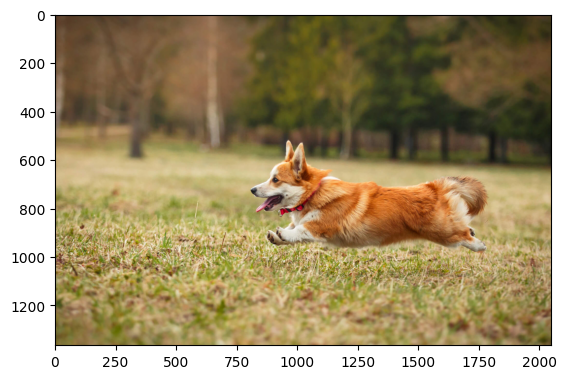

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import cv2
import os
from sklearn.kernel_approximation import RBFSampler
try:
  from einops import rearrange
except ModuleNotFoundError:
  %pip install einops
  from einops import rearrange

import warnings

# Remove warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Download image if not exists
if not os.path.exists('frog.jpg'):
    !wget https://segment-anything.com/assets/gallery/GettyImages-1191014275.jpg -O frog.jpg

if not os.path.exists('dog.jpg'):
   !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Read image using torchvision
# frog_img = torchvision.io.read_image("frog.jpg")
# print(f"Original Image Shape: {frog_img.shape}")

# # Display image
# plt.imshow(rearrange(frog_img, 'c h w -> h w c').numpy())
# plt.show()

dog_img = torchvision.io.read_image('dog.jpg')
print(f"Original Image Shape: {dog_img.shape}")

plt.imshow(rearrange(dog_img, 'c h w -> h w c').numpy())
plt.show()

In [2]:
# Min-Max scaling
scaler_img = preprocessing.MinMaxScaler().fit(dog_img.reshape(-1, 1))
img_scaled = scaler_img.transform(dog_img.reshape(-1, 1)).reshape(dog_img.shape)
img_scaled = torch.tensor(img_scaled, dtype=torch.float32).to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

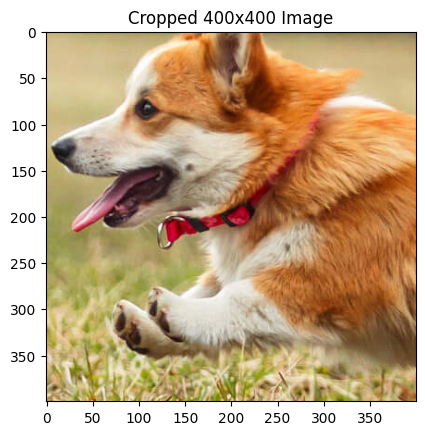

In [3]:

# Crop the image (400x400)
highResImg = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400).to(device)
plt.imshow(rearrange(highResImg, 'c h w -> h w c').cpu().numpy())
plt.title("Cropped 400x400 Image")
plt.show()


In [4]:

# Resize to simulate low-resolution image (200x200)
crop_image_np = rearrange(highResImg, 'c h w -> h w c').cpu().numpy()
lowResImg = cv2.resize(crop_image_np, (200, 200), interpolation=cv2.INTER_AREA)
lowResImg = rearrange(lowResImg, 'h w c -> c h w')


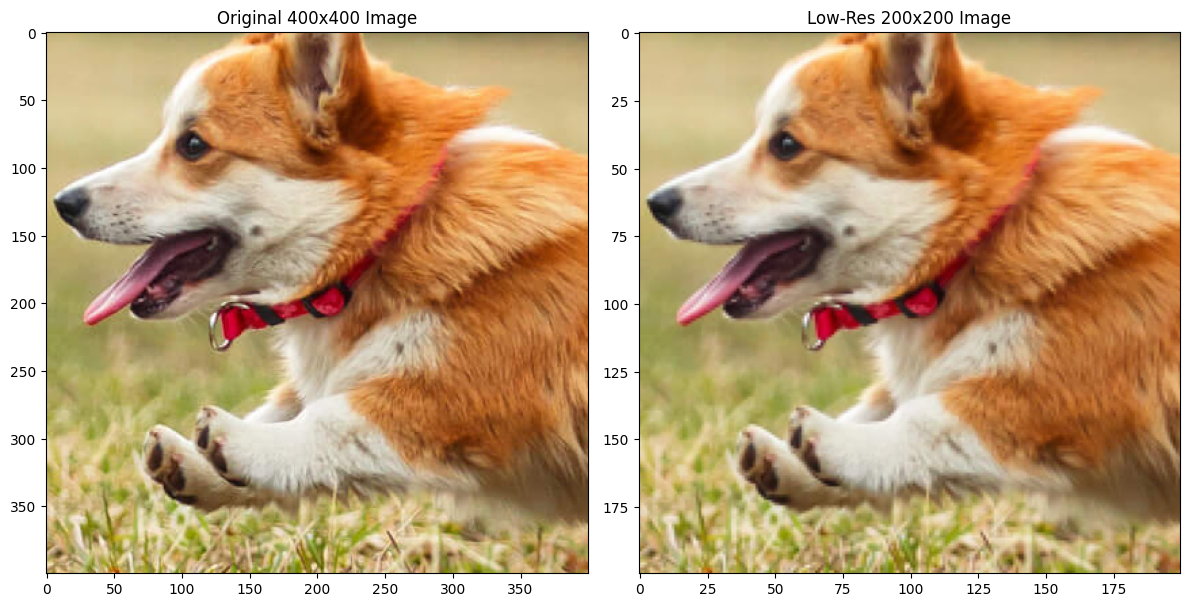

In [5]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Plot the original 400x400 image
ax0 = plt.subplot(gs[0])
ax0.imshow(rearrange(highResImg, 'c h w -> h w c').cpu().numpy())
ax0.set_title('Original 400x400 Image')

# Plot the low-res 200x200 image
ax1 = plt.subplot(gs[1])
ax1.imshow(rearrange(lowResImg, 'c h w -> h w c'))
ax1.set_title('Low-Res 200x200 Image')

plt.tight_layout()
plt.show()

In [6]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [7]:

# Define Linear Model
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()

In [8]:
def plot_original_vs_super_resolved_img(original_img, X_rff_super_resolved, net, scale = 2, output = 0):

    num_channels, height, width = original_img.shape

    height *= scale
    width *= scale

    with torch.no_grad():
        outputs = net(X_rff_super_resolved)
        super_r_img = outputs.reshape(height, width, num_channels).to(device)

    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height//scale}x{width//scale})')
    ax0.imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Enhanced Image ({height}x{width})')
    # The code was previously reshaping the image again. This is unnecessary since it was reshaped a few lines earlier
    ax1.imshow(super_r_img.cpu().detach().numpy())

    fig.suptitle('Original vs Enhanced Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

    return super_r_img

In [9]:
import gc
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler


def enhance_image(lowResImg, num_features, sigma = 0.04, lr = 0.02, epochs = 1000, device = 'cpu'):

    X, Y = create_coordinate_map(lowResImg)
    Y = Y.to(device)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)

    rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
    X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)

    net = LinearModel(X_rff.shape[1],lowResImg.shape[0]).to(device)
    train(net, lr, X_rff, Y, epochs)

    del X_rff, X, Y, scaled_X, scaler
    gc.collect()

    X_, Y_ = create_coordinate_map(lowResImg,scale=2)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
    scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)

    X_rff = torch.tensor(rff.transform(scaled_X_.cpu().numpy())).float().to(device)
    print("\nComparison Between Low Resolution image and Enhanced image:")

    new_img = plot_original_vs_super_resolved_img(lowResImg, X_rff, net)
    del net, X_rff, X_, Y_, scaled_X_, scaler
    gc.collect()

    return new_img

Epoch 0 loss: 0.369069
Epoch 100 loss: 0.019064
Epoch 200 loss: 0.001203
Epoch 300 loss: 0.000249
Epoch 400 loss: 0.000150
Epoch 500 loss: 0.000139
Epoch 600 loss: 0.000136
Epoch 700 loss: 0.000134
Epoch 800 loss: 0.000133
Epoch 900 loss: 0.000132
Epoch 1000 loss: 0.000131
Epoch 1100 loss: 0.000130
Epoch 1200 loss: 0.000130
Epoch 1300 loss: 0.000129
Epoch 1400 loss: 0.000129
Epoch 1500 loss: 0.000128
Epoch 1600 loss: 0.000128
Epoch 1700 loss: 0.000128
Epoch 1800 loss: 0.000128
Epoch 1900 loss: 0.000127
Epoch 2000 loss: 0.000127
Epoch 2100 loss: 0.000127
Epoch 2200 loss: 0.000127
Epoch 2300 loss: 0.000127
Epoch 2400 loss: 0.000126
Epoch 2500 loss: 0.000126
Epoch 2600 loss: 0.000126
Epoch 2700 loss: 0.000126
Epoch 2800 loss: 0.000126
Epoch 2900 loss: 0.000126
Epoch 3000 loss: 0.000125

Comparison Between Low Resolution image and Enhanced image:


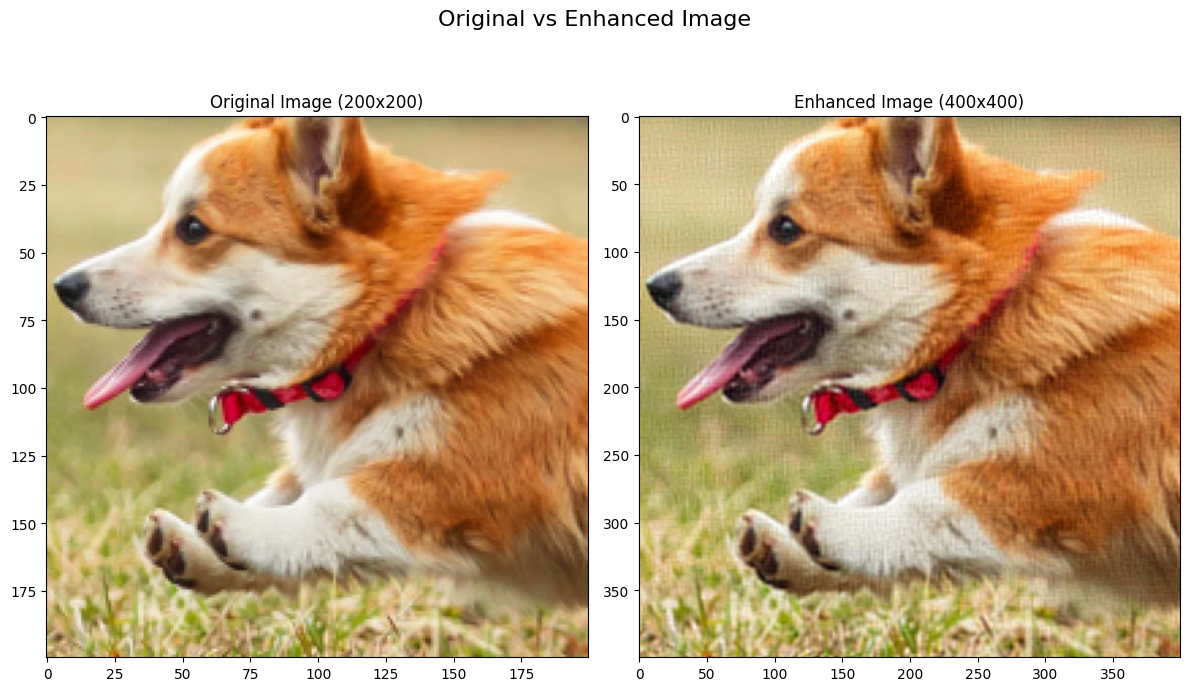

In [14]:
lowResImg = torch.tensor(lowResImg, dtype=torch.float32).to(device)
higResOutputImg = enhance_image(lowResImg,80000,sigma = 0.009, epochs=3000, lr=0.006)

Original highResImg vs Predicted highResImg


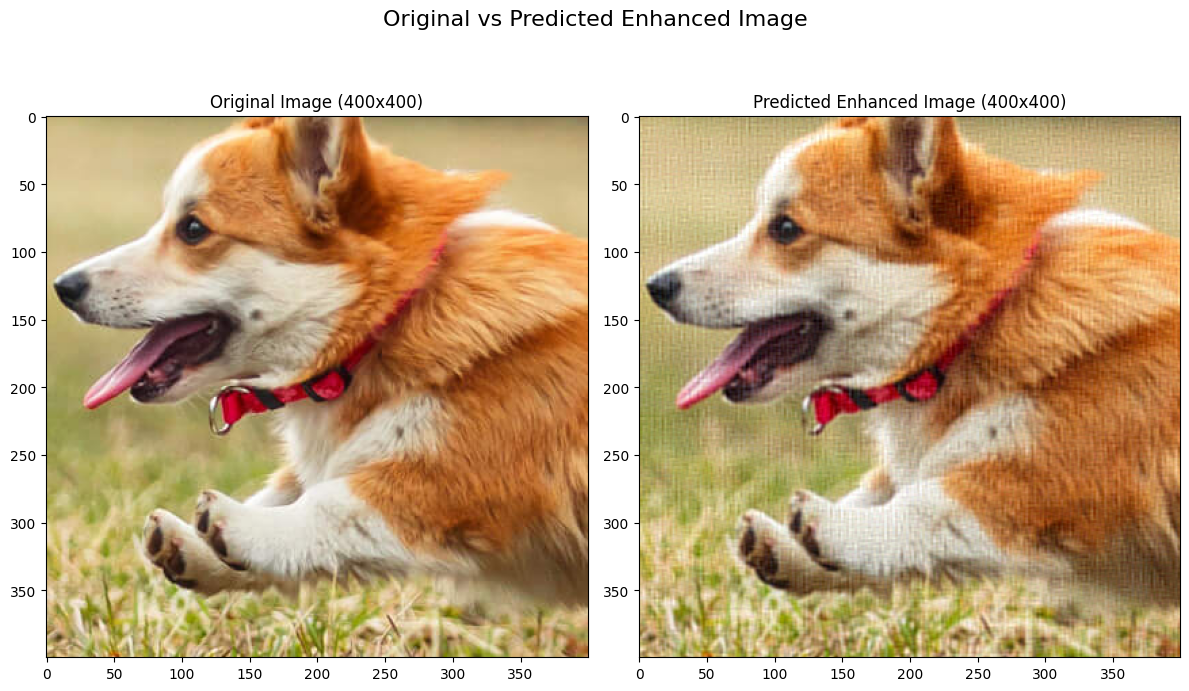

In [11]:
print("Original highResImg vs Predicted highResImg")
def plot_comparison(original_img, pred_img):
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    height, width = original_img.shape[1], original_img.shape[2]

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Enhanced Image ({height}x{width})')
    ax1.imshow(pred_img.cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Enhanced Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

plot_comparison(highResImg, higResOutputImg)

In [15]:
def rmse(y_true, y_pred):
    # Ensure tensors have the same shape. Rearrange y_true if necessary
    if y_true.shape != y_pred.shape:
        y_pred = rearrange(y_pred, 'h w c-> c h w ')

    assert y_true.shape == y_pred.shape, "y and y_pred must have the same shape"

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

rmse(highResImg, higResOutputImg)

tensor(0.0286)

In [16]:
def psnr(y_true, y_pred):
  if y_true.shape != y_pred.shape:
        y_pred = rearrange(y_pred, 'h w c-> c h w ')

  assert y_true.shape == y_pred.shape, "Input shapes must match."

  y_true = y_true.flatten()
  y_pred = y_pred.flatten()
  mse = torch.mean((y_true - y_pred) ** 2)
  max_pixel = torch.max(y_true)
  return 20 * torch.log10(max_pixel / torch.sqrt(mse))

psnr(highResImg, higResOutputImg)

tensor(30.8589)